# Time Series Classification and Clustering Assignment

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans

### Import the Walmart stock price data set (WMT_data.csv).

In [2]:
walmart = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Data%20Sets%20Time%20Series%20Analysis/Time%20Series%20-%20Day%205/WMT_data.csv')
walmart.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,71.20,71.64,71.070,71.48,5906823,WMT
1,2013-02-11,71.25,71.51,70.530,71.40,6202534,WMT
2,2013-02-12,71.49,71.66,71.100,71.40,4761910,WMT
3,2013-02-13,71.29,71.70,71.210,71.39,3969807,WMT
4,2013-02-14,71.10,71.23,70.755,70.82,6820952,WMT


In [3]:
walmart['date'] = pd.to_datetime(walmart['date'])
walmart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1259 non-null   datetime64[ns]
 1   open    1259 non-null   float64       
 2   high    1259 non-null   float64       
 3   low     1259 non-null   float64       
 4   close   1259 non-null   float64       
 5   volume  1259 non-null   int64         
 6   Name    1259 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 69.0+ KB


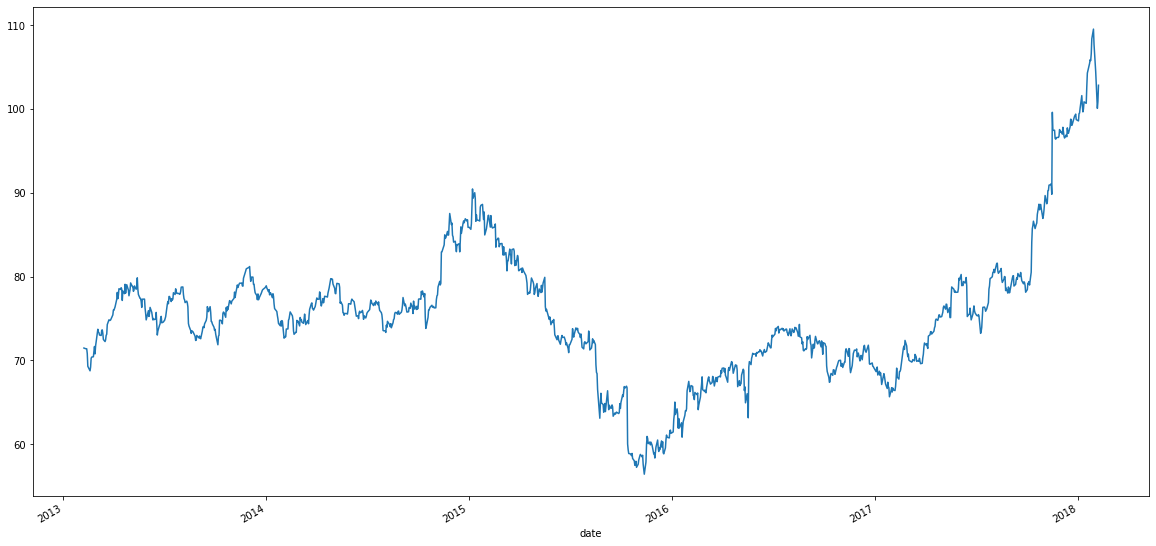

In [5]:
walmart.set_index('date')['close'].plot(kind='line', figsize=(20,10))

### Transform the data to be able to predict minor direction changes in the stock's price, given 180 days of history.

- Remember to calculate daily returns from the observed values (closing price).
- Make the critera for identifying a direction change when the observed values (closing price) cross the 5 day moving average.
- Create a binary column that defaults to 0 unless the criteria is met (then updates to 1).
- Shift the data set so that you have 180 days of history for each record.

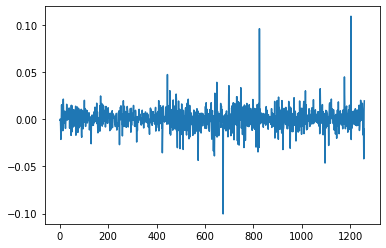

In [7]:
#returns
walmart['Returns'] = walmart['close'].pct_change()

walmart.Returns.plot() #stationary

In [8]:
#rolling moving avg 5 days
walmart['MA_5'] = walmart['close'].rolling(5).mean()

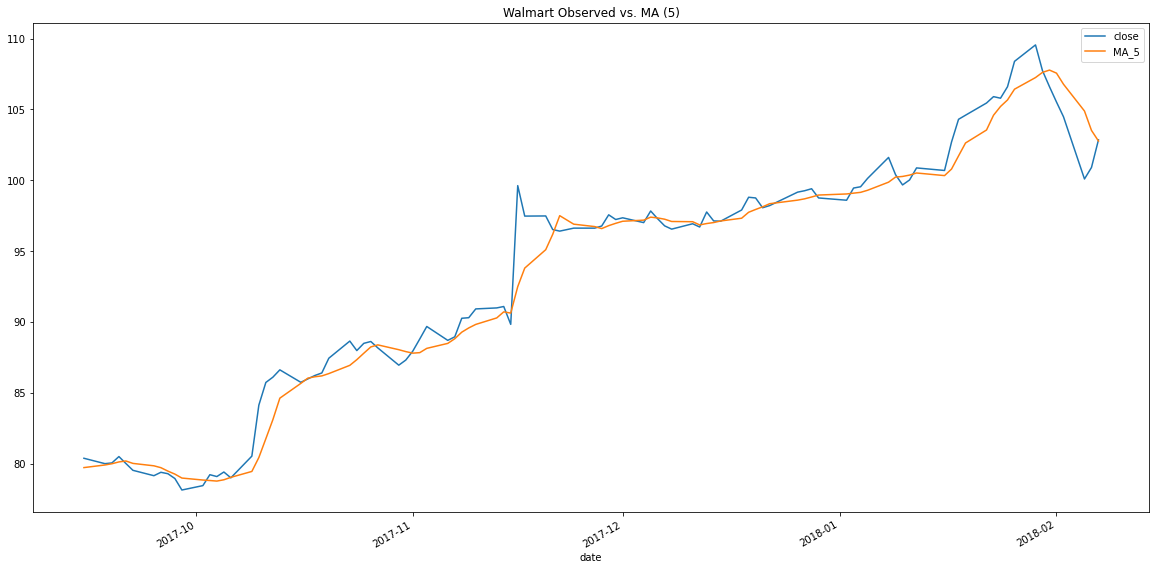

In [19]:
#graph of moving avg vs observed
walmart.set_index('date')[['close', 'MA_5']].iloc[-100:].plot(figsize=(20,10), title='Walmart Observed vs. MA (5)')

In [14]:
#create trend column
walmart['Trend'] = 'None'

walmart.loc[(walmart['MA_5'] < walmart['close']), 'Trend'] = 'Negative'
walmart.loc[(walmart['MA_5'] > walmart['close']), 'Trend'] = 'Positive'
walmart.tail()

,date,open,high,low,close,volume,Name,Returns,MA_5,Trend
1254,2018-02-01,105.96,106.56,105.18,105.52,6386836,WMT,-0.010131,107.558,Positive
1255,2018-02-02,105.15,106.47,104.15,104.48,9253068,WMT,-0.009856,106.776,Positive
1256,2018-02-05,103.40,104.61,97.09,100.09,12561594,WMT,-0.042018,104.884,Positive
1257,2018-02-06,97.64,101.08,97.25,100.90,16413797,WMT,0.008093,103.518,Positive
1258,2018-02-07,100.50,104.59,100.01,102.85,11165223,WMT,0.019326,102.768,Negative


In [17]:
#shift column set as 'Change'
walmart['Change'] = walmart['Trend'].eq(walmart['Trend'].shift())
walmart.tail()

,date,open,high,low,close,volume,Name,Returns,MA_5,Trend,Change
1254,2018-02-01,105.96,106.56,105.18,105.52,6386836,WMT,-0.010131,107.558,Positive,True
1255,2018-02-02,105.15,106.47,104.15,104.48,9253068,WMT,-0.009856,106.776,Positive,True
1256,2018-02-05,103.40,104.61,97.09,100.09,12561594,WMT,-0.042018,104.884,Positive,True
1257,2018-02-06,97.64,101.08,97.25,100.90,16413797,WMT,0.008093,103.518,Positive,True
1258,2018-02-07,100.50,104.59,100.01,102.85,11165223,WMT,0.019326,102.768,Negative,False


In [18]:
#creating Binary column -- will be y
#default 0 unless condition met
walmart['Binary'] = 0
walmart.loc[(walmart['Change']==False) & (walmart['Trend'] != 'None'), 'Binary'] = 1

#dropping nans
walmart.dropna(inplace=True)
walmart.head()

,date,open,high,low,close,volume,Name,Returns,MA_5,Trend,Change,Binary
4,2013-02-14,71.10,71.23,70.755,70.82,6820952,WMT,-0.007984,71.298,Positive,False,1
5,2013-02-15,69.54,70.00,68.130,69.30,25687156,WMT,-0.021463,70.862,Positive,True,0
6,2013-02-19,69.19,69.45,68.540,68.76,14683322,WMT,-0.007792,70.334,Positive,True,0
7,2013-02-20,68.72,69.85,68.300,69.21,11973720,WMT,0.006545,69.896,Positive,True,0
8,2013-02-21,70.00,71.47,69.720,70.26,20425983,WMT,0.015171,69.670,Negative,False,1


In [20]:
#shift 180 days
transformed = walmart[['date', 'Returns', 'Binary']]

history = 180
future = 0

shifts = [x + future for x in range(1, history + 1)]

for shift in shifts:
    transformed['t-' + str(shift)] = transformed['Returns'].shift(shift)

transformed.dropna(inplace=True)
transformed.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,date,Returns,Binary,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10,t-11,t-12,t-13,t-14,t-15,t-16,t-17,t-18,t-19,t-20,t-21,t-22,t-23,t-24,t-25,t-26,t-27,t-28,t-29,t-30,t-31,t-32,t-33,t-34,t-35,t-36,t-37,...,t-141,t-142,t-143,t-144,t-145,t-146,t-147,t-148,t-149,t-150,t-151,t-152,t-153,t-154,t-155,t-156,t-157,t-158,t-159,t-160,t-161,t-162,t-163,t-164,t-165,t-166,t-167,t-168,t-169,t-170,t-171,t-172,t-173,t-174,t-175,t-176,t-177,t-178,t-179,t-180
184,2013-10-31,-0.002080,1,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,0.015569,-0.007397,-0.000924,0.002381,0.016539,-0.004151,-0.001871,0.000401,0.024521,0.001372,0.014331,-0.012775,-0.004921,-0.007596,0.001767,-0.005003,-0.005379,-0.003484,-0.000402,-0.014521,-0.008767,0.007781,-0.004986,-0.002748,0.016900,0.004948,0.005648,0.006088,-0.001891,0.001217,0.006122,...,0.009898,0.005428,-0.009601,0.010739,0.011782,0.002493,0.002632,-0.000263,0.007822,0.008018,0.000669,0.000134,-0.001069,0.007674,0.015725,0.001918,0.007453,0.002768,-0.003448,-0.009833,-0.005838,0.000679,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171,0.006545,-0.007792,-0.021463,-0.007984
185,2013-11-01,0.004169,1,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,0.015569,-0.007397,-0.000924,0.002381,0.016539,-0.004151,-0.001871,0.000401,0.024521,0.001372,0.014331,-0.012775,-0.004921,-0.007596,0.001767,-0.005003,-0.005379,-0.003484,-0.000402,-0.014521,-0.008767,0.007781,-0.004986,-0.002748,0.016900,0.004948,0.005648,0.006088,-0.001891,0.001217,...,-0.001146,0.009898,0.005428,-0.009601,0.010739,0.011782,0.002493,0.002632,-0.000263,0.007822,0.008018,0.000669,0.000134,-0.001069,0.007674,0.015725,0.001918,0.007453,0.002768,-0.003448,-0.009833,-0.005838,0.000679,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171,0.006545,-0.007792,-0.021463
186,2013-11-04,0.003374,0,0.004169,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,0.015569,-0.007397,-0.000924,0.002381,0.016539,-0.004151,-0.001871,0.000401,0.024521,0.001372,0.014331,-0.012775,-0.004921,-0.007596,0.001767,-0.005003,-0.005379,-0.003484,-0.000402,-0.014521,-0.008767,0.007781,-0.004986,-0.002748,0.016900,0.004948,0.005648,0.006088,-0.001891,...,0.002676,-0.001146,0.009898,0.005428,-0.009601,0.010739,0.011782,0.002493,0.002632,-0.000263,0.007822,0.008018,0.000669,0.000134,-0.001069,0.007674,0.015725,0.001918,0.007453,0.002768,-0.003448,-0.009833,-0.005838,0.000679,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171,0.006545,-0.007792
187,2013-11-05,0.001164,0,0.003374,0.004169,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,0.015569,-0.007397,-0.000924,0.002381,0.016539,-0.004151,-0.001871,0.000401,0.024521,0.001372,0.014331,-0.012775,-0.004921,-0.007596,0.001767,-0.005003,-0.005379,-0.003484,-0.000402,-0.014521,-0.008767,0.007781,-0.004986,-0.002748,0.016900,0.004948,0.005648,0.006088,...,-0.002161,0.002676,-0.001146,0.009898,0.005428,-0.009601,0.010739,0.011782,0.002493,0.002632,-0.000263,0.007822,0.008018,0.000669,0.000134,-0.001069,0.007674,0.015725,0.001918,0.007453,0.002768,-0.003448,-0.009833,-0.005838,0.000679,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171,0.006545
188,2013-11-06,0.009558,0,0.001164,0.003374,0.004169,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,0.015569,-0.007397,-0.000924,0.002381,0.016539,-0.004151,-0.001871,0.000401,0.024521,0.001372,0.014331,-0.012775,-0.004921,-0.007596,0.001767,-0.005003,-0.005379,-0.003484,-0.000402,-0.014521,-0.008767,0.007781,-0.004986,-0.002748,0.016900,0.004948,0.005648,...,-0.017195,-0.002161,0.002676,-0.001146,0.009898,0.005428,-0.009601,0.010739,0.011782,0.002493,0.002632,-0.000263,0.007822,0.008018,0.000669,0.00013

### Train a Logistic Regression classification model on the transformed data.

In [21]:
#splitting data for model
X = transformed.drop(['date', 'Returns', 'Binary'], axis=1)
y = transformed['Binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) #make sure shuffle=False

In [23]:
#see value counts for y_train
y_train.value_counts() #has an imbalance

0    626
1    234
Name: Binary, dtype: int64

In [24]:
#fitting LogReg model
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)
predictions = model.predict(X_test)

### Run a classification report and evaluate the performance of the classifier.

In [25]:
#classification report for LogReg
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.78      0.63      0.70       161
           1       0.30      0.46      0.36        54

    accuracy                           0.59       215
   macro avg       0.54      0.55      0.53       215
weighted avg       0.66      0.59      0.61       215



### Transform the data again to have 10 days of history for clustering.

In [27]:
#clustering
transformed = walmart[['date', 'Returns', 'Binary']]

#10 days history
history = 10
future = 0

shifts = [x + future for x in range(1, history+1)]

for shift in shifts:
    transformed['t-' + str(shift)] = transformed['Returns'].shift(shift)

transformed.dropna(inplace=True)

x = transformed.drop(['date', 'Returns', 'Binary'], axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


### Train a K Means clustering model on the data. 

Try different values for K and see how the summary changes.

In [28]:
#k-means function for clustering
def kmeans(df, clusters=2):
    model = KMeans(n_clusters=clusters, random_state=42)
    clusters = model.fit_predict(df)
    results = df.copy()
    results['Cluster'] = clusters
    
    cluster_size = results.groupby(['Cluster']).size().reset_index()
    cluster_size.columns = ['Cluster', 'Count']
    cluster_means = results.groupby(['Cluster'], as_index=False).mean()
    summary = pd.merge(cluster_size, cluster_means, on='Cluster')
    
    return results, summary

In [35]:
#cluster =8
results, summary = kmeans(x, clusters=8)
summary

,Cluster,Count,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
0,0,173,0.009804,-0.000120,0.002878,-0.000735,-0.010445,0.000775,0.001749,0.001726,-0.000331,-0.002694
1,1,113,-0.004945,-0.014817,-0.000686,-0.001094,0.000729,-0.006952,-0.000540,0.001098,-0.001906,0.002032
2,2,149,-0.001077,0.003326,-0.000032,0.005125,0.000429,-0.002953,0.000128,0.011164,-0.009119,-0.000514
3,3,187,-0.004160,0.000810,0.005418,-0.000192,0.000814,-0.000723,0.000258,0.002550,0.011676,-0.003640
4,4,166,-0.002052,-0.001039,0.000576,0.008268,-0.002165,0.002013,0.009231,-0.008039,-0.000359,0.004054
5,5,131,0.001074,0.002943,0.005081,0.000086,0.000618,0.006235,-0.011650,-0.001269,-0.000005,0.010909
6,6,197,0.001475,0.007589,-0.008392,-0.007428,0.002274,-0.001909,0.001268,-0.001826,0.000825,0.001430
7,7,129,0.000982,-0.001891,-0.000539,0.000624,0.014177,0.007499,-0.000202,-0.001414,-0.001339,-0.007161


In [30]:
#cluster = 4
results, summary = kmeans(x, clusters=4)
summary

,Cluster,Count,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
0,0,342,-0.000538,-0.003050,0.001500,0.001139,0.006945,0.003281,-0.001373,-0.002827,-0.003312,0.006604
1,1,309,0.003063,0.001218,0.005680,-0.003284,-0.006280,0.001351,0.006946,0.000175,-0.002608,-0.001101
2,2,312,-0.006878,0.002170,-0.000309,0.005120,-0.001133,-0.006375,0.000642,0.005616,0.002324,-0.000424
3,3,282,0.006382,0.001437,-0.006044,-0.001753,0.001449,0.003422,-0.004746,-0.001132,0.006012,-0.004681


In [38]:
results, summary = kmeans(x, clusters=12)
summary

,Cluster,Count,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
0,0,113,0.001351,0.003886,0.000530,-0.001202,-0.015307,0.001550,0.003203,0.002648,-0.001850,-0.002487
1,1,143,-0.011259,-0.009766,0.000079,-0.001504,0.000427,0.000355,0.000785,0.000794,0.001475,-0.003247
2,2,64,-0.002017,-0.002501,0.002401,0.013759,-0.002548,-0.003694,-0.004812,0.015791,-0.007449,0.000869
3,3,141,0.003888,0.001274,0.000790,-0.000600,0.001684,-0.000175,0.000351,0.008030,0.011943,-0.001749
4,4,140,0.003007,-0.000854,0.002859,0.006785,-0.000082,0.001306,0.011472,-0.006488,-0.000937,-0.000643
5,5,82,0.000661,-0.001254,0.018492,-0.001204,-0.000260,0.002412,-0.003413,-0.001203,-0.000071,0.004382
6,6,100,-0.001577,0.008401,-0.001104,-0.000114,0.002306,-0.014579,-0.000599,-0.002279,0.004193,0.000906
7,7,142,-0.001633,0.007164,-0.000533,-0.001189,0.010434,0.004001,0.001118,0.002992,-0.008292,-0.004284
8,8,48,-0.003943,0.002368,0.000121,0.005311,0.000363,0.005196,-0.021744,-0.011301,0.004376,-0.002521
9,9,95,0.000137,0.002147,-0.001500,0.000332,-0.001072,0.006384,-0.000352,-0.002278,0.001740,0.016951


### Visualize the summary of the clustering results as a heatmap.

Text(0.5, 1.0, 'Walmart Cluster Avg. Values (cluster=4)')

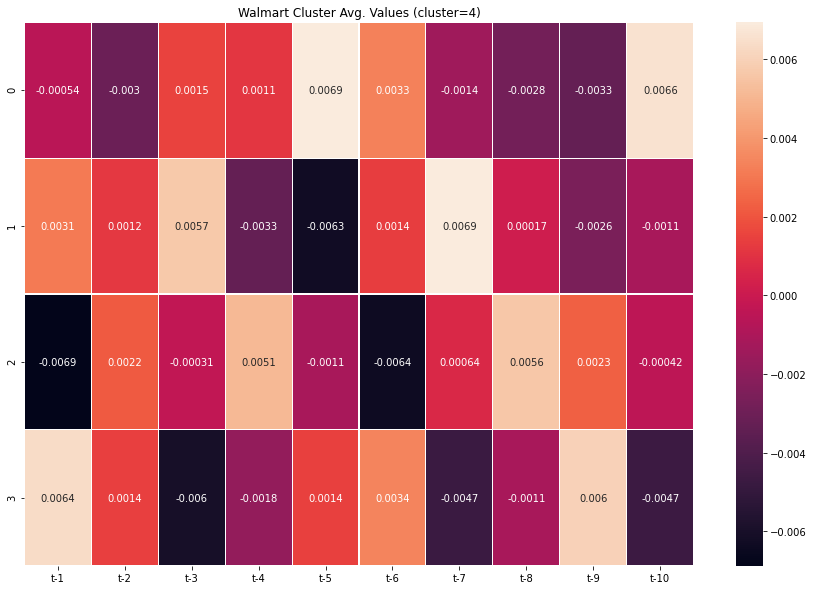

In [34]:
plt.figure(figsize=(15,10))
sns.heatmap(summary.drop(columns=['Cluster', 'Count']), annot=True, linewidths=0.01)
plt.title('Walmart Cluster Avg. Values (cluster=4)')

Text(0.5, 1.0, 'Walmart Cluster Avg. Values (cluster=8)')

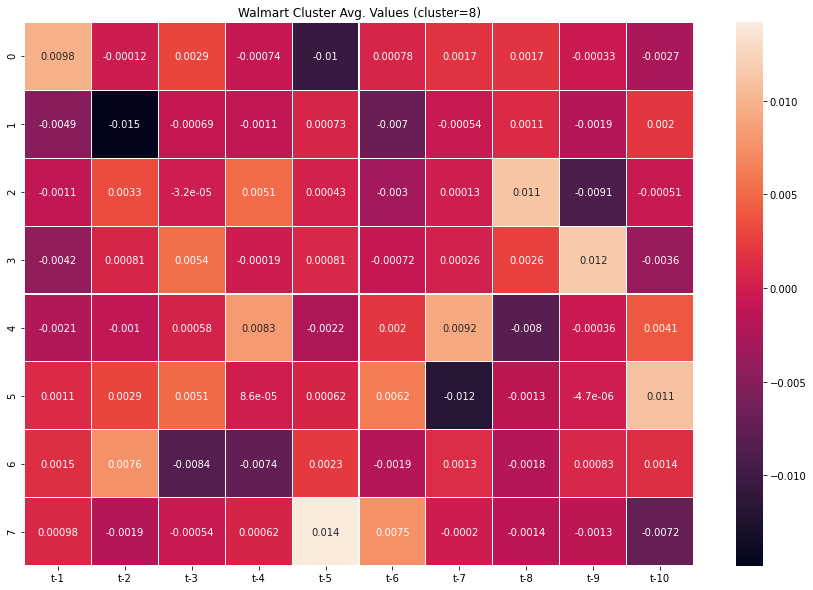

In [36]:
plt.figure(figsize=(15,10))
sns.heatmap(summary.drop(columns=['Cluster', 'Count']), annot=True, linewidths=0.01)
plt.title('Walmart Cluster Avg. Values (cluster=8)')

Text(0.5, 1.0, 'Walmart Cluster Avg. Values (cluster=12)')

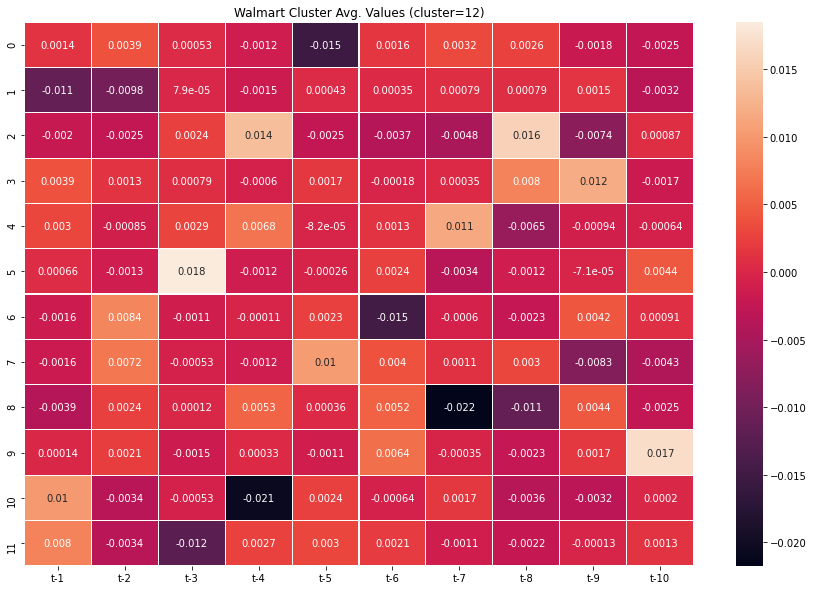

In [39]:
plt.figure(figsize=(15,10))
sns.heatmap(summary.drop(columns=['Cluster', 'Count']), annot=True, linewidths=0.01)
plt.title('Walmart Cluster Avg. Values (cluster=12)')